## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images, and record the images that can't use to calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
fail_cali = []

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
print(len(images))

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(2000)
    else:
        fail_cali.append(fname)

print(fail_cali)
cv2.destroyAllWindows()

20
['../camera_cal\\calibration1.jpg', '../camera_cal\\calibration4.jpg', '../camera_cal\\calibration5.jpg']


### Apply a distortion correction to a raw image

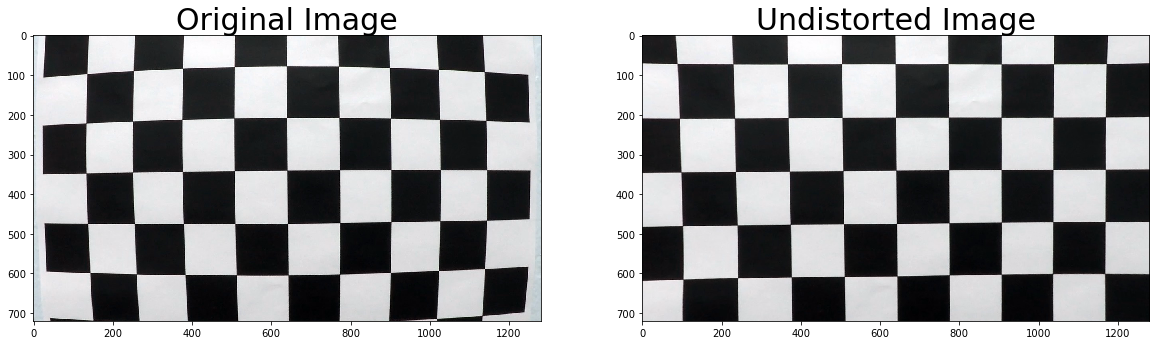

In [2]:
import pickle
%matplotlib inline

# a raw image
test_img = cv2.imread(fail_cali[0])
cv2.imshow('test_distortion',test_img)
cv2.waitKey(2000)
img_size = (test_img.shape[1], test_img.shape[0])

#compute the camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "../output_images/wide_dist_pickle.p", "wb" ) )

#undistort
dst = cv2.undistort(test_img, mtx, dist, None, mtx)
cv2.imshow('undistort', dst)
cv2.waitKey(2000)
cv2.imwrite('../output_images/undistort.jpg', dst)
cv2.destroyAllWindows()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize = 30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('../output_images/comparison.jpg')

# Check points to read undistort params

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

In [2]:
with open('..//output_images//wide_dist_pickle.p','rb') as p:
    dist_data = pickle.load(p)
    mtx = dist_data['mtx']
    dist = dist_data['dist']

### distortion-corrected

In [3]:
def get_undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

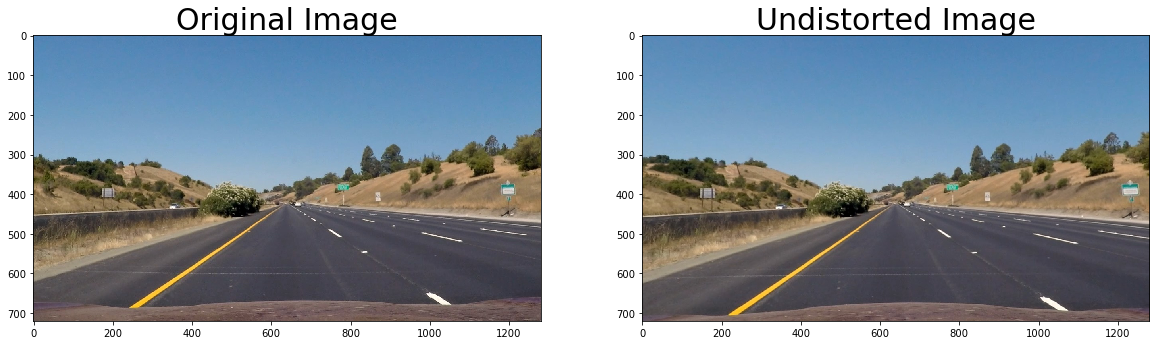

In [4]:
names = glob.glob('..\\test_images\\*.jpg')
img = mpimg.imread(names[0])

undistortion = get_undistort(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize = 30)
ax2.imshow(undistortion)
ax2.set_title('Undistorted Image', fontsize=30)

plt.savefig('..\\output_images\\undistort.jpg')

### Perspective Transform

In [5]:
# Calculate the parameters of perspective transformation
perspective_src = np.float32(
    [[603,445],
     [679,445],
     [1058, 688],
     [254, 688]])
perspective_des = np.float32(
    [[330, 0],
     [950, 0],
     [950, 720],
     [330, 720]]
)
names = glob.glob('..\\test_images\\*.jpg')
img = mpimg.imread(names[0])
img_size = (img.shape[1], img.shape[0])
M = cv2.getPerspectiveTransform(perspective_src, perspective_des)
res_M = cv2.getPerspectiveTransform(perspective_des,perspective_src)

def pers_transform(img_):
    return cv2.warpPerspective(img_, M, img_size, flags=cv2.INTER_LINEAR)

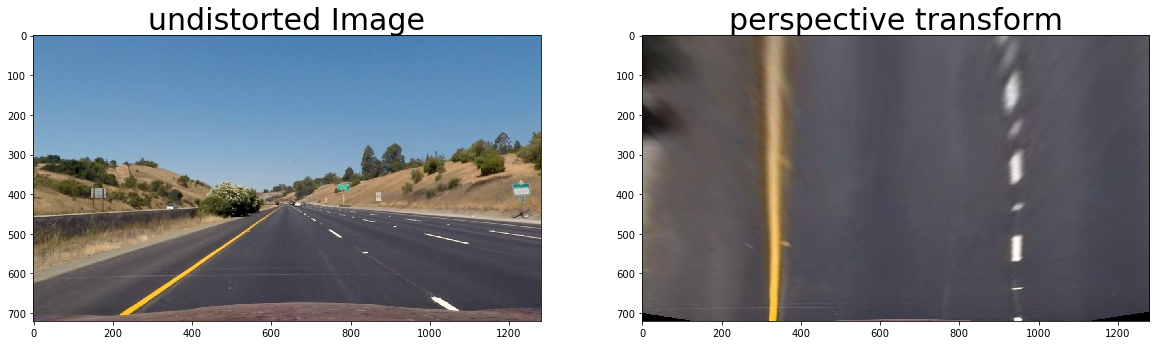

In [6]:
import matplotlib.image as mpimg

test_imgs = glob.glob('..//test_images//str*.jpg')
test_img = test_imgs[0]
src = mpimg.imread(test_img)
undistort = get_undistort(src)
wraped = pers_transform(undistort)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undistort)
ax1.set_title('undistorted Image',fontsize=30)
ax2.imshow(wraped)
ax2.set_title('perspective transform', fontsize=30)
plt.show()

### Gradient Threshold

In [7]:
# Sobel Operator
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3,thresh=(50,255)):
    if orient=='x':
        sobel_ = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel_ = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_so = np.absolute(sobel_)
    scaled_so = np.uint8(255*abs_so/np.max(abs_so))
    result = np.zeros_like(scaled_so)
    result[(scaled_so>=thresh[0])&(scaled_so<=thresh[1])] = 1
    return result

# Magnitude of the Gradient
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(70,255)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    gradmag = np.sqrt( sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag>=mag_thresh[0])&(gradmag<=mag_thresh[1])] = 1
    return binary_output

# Direction of the Gradient
def dir_thresh(gray, sobel_kernel=3, dir_thresh=(0.7, 1.3)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    absgraddir = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir>=dir_thresh[0]) & (absgraddir<=dir_thresh[1])] = 1
    
    return binary_output

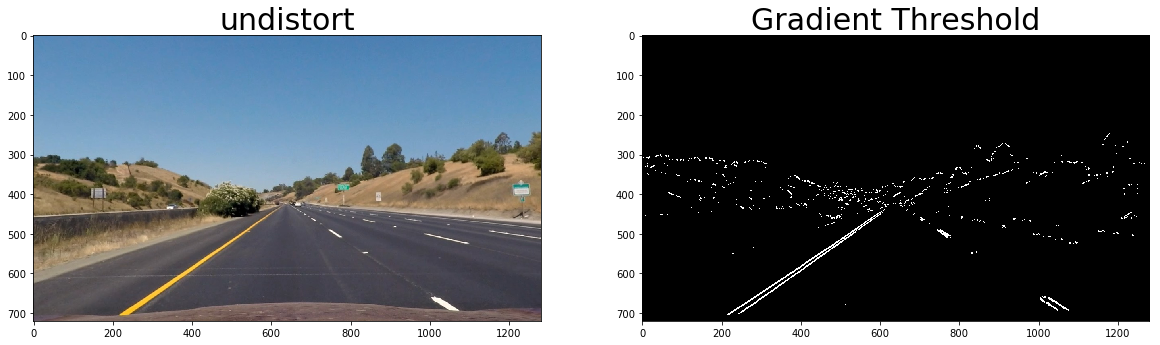

In [8]:
gray = cv2.cvtColor(undistort,cv2.COLOR_RGB2GRAY)
ker_size = 9
gradx = abs_sobel_thresh(gray, orient='x',sobel_kernel=ker_size, thresh=(50,255) )
grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ker_size, thresh=(50,255))

mag_bin = mag_thresh(gray, sobel_kernel=ker_size, mag_thresh=(70,255))
dir_bin = dir_thresh(gray, sobel_kernel=ker_size, dir_thresh=(0.7,1.3))

gradient = np.zeros_like(dir_bin)
gradient[((gradx==1) & (grady==1)) | ((mag_bin==1)&(dir_bin==1))] = 1

f,(ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(undistort)
ax1.set_title('undistort',fontsize=30)
ax2.imshow(gradient,cmap='gray')
ax2.set_title('Gradient Threshold',fontsize=30)

plt.savefig('..\\output_images\\gradient_thershold.jpg')

### hls channels

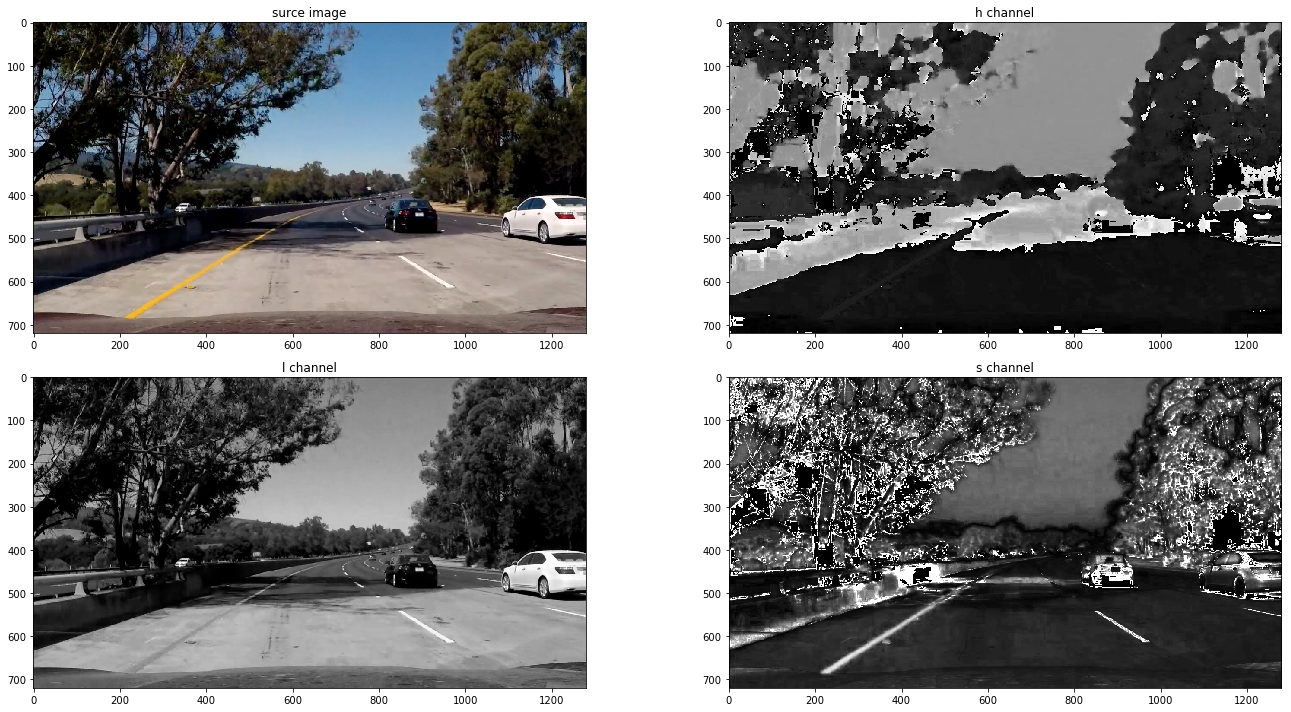

In [14]:
img = mpimg.imread('..\\test_images\\test5.jpg')
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

f, axes = plt.subplots(2,2, figsize=(20,10))
axes[0][0].imshow(img)
axes[0][0].set_title('surce image')

axes[0][1].imshow(hls[:,:,0], cmap='gray')
axes[0][1].set_title('h channel')

axes[1][0].imshow(hls[:,:,1], cmap='gray')
axes[1][0].set_title('l channel')

axes[1][1].imshow(hls[:,:,2], cmap='gray')
axes[1][1].set_title('s channel')

plt.tight_layout()

plt.savefig('..\\output_images\\three_channels.jpg')

### Color space threshold: Saturation Threshold

In [16]:
# Saturation threshold to get binary image
def hls_select(img,l_thresh=(30,200), s_thresh=(165, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Histogram equalization for s channel
    s_channel = cv2.equalizeHist(hls[:, :, 2])
    l_channel = hls[:, :, 1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # get l channel's lanes' pixes
    l_binary_zero = np.zeros_like(l_channel)
    l_binary_zero[l_channel > l_thresh[1]] = 1

    # Exclude shadow interference
    l_binary_one = np.ones_like(l_channel)
    l_binary_one[l_channel < l_thresh[0]] = 0

    s_high = np.zeros_like(l_channel)
    s_high[(s_binary == 1) | (l_binary_zero == 1)] = 1
    s_high_low = np.zeros_like(l_channel)
    s_high_low[(s_high == 1) & (l_binary_one == 1)] = 1
    return s_high_low

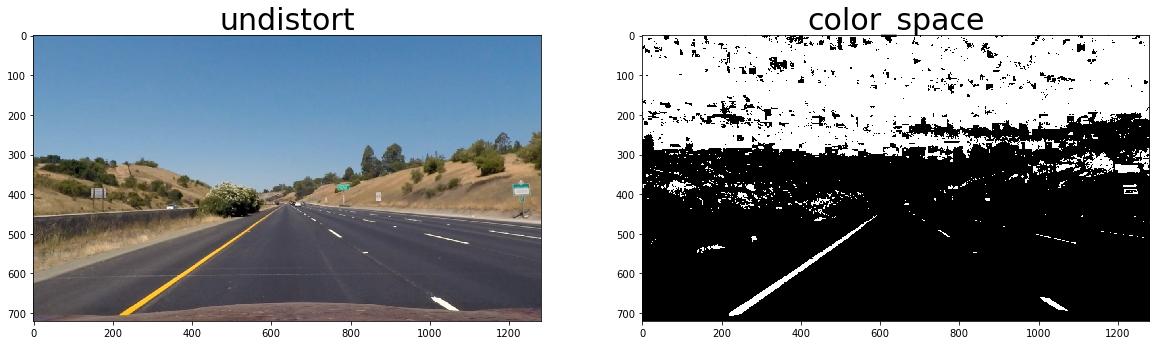

In [17]:
sat_thre = hls_select(undistort)

f,(ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(undistort)
ax1.set_title('undistort',fontsize=30)
ax2.imshow(sat_thre,cmap='gray')
ax2.set_title('color_space',fontsize=30)
plt.savefig('..\\output_images\\color_space.jpg')

### Combined gradient and saturation threshold

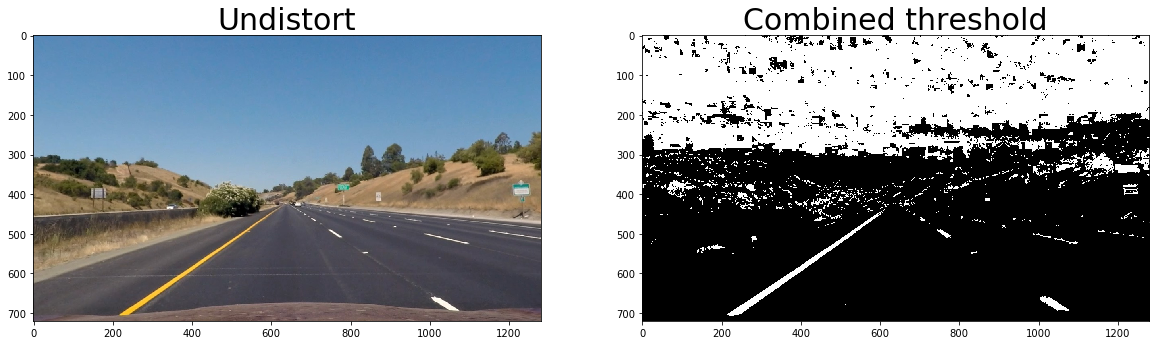

In [19]:
combined = np.zeros_like(sat_thre)
combined[(sat_thre==1) | (gradient==1)] = 1

f,(ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(undistort)
ax1.set_title('Undistort',fontsize=30)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined threshold',fontsize=30)

plt.savefig('..\\output_images\\Combined.jpg')

### Perspective transform

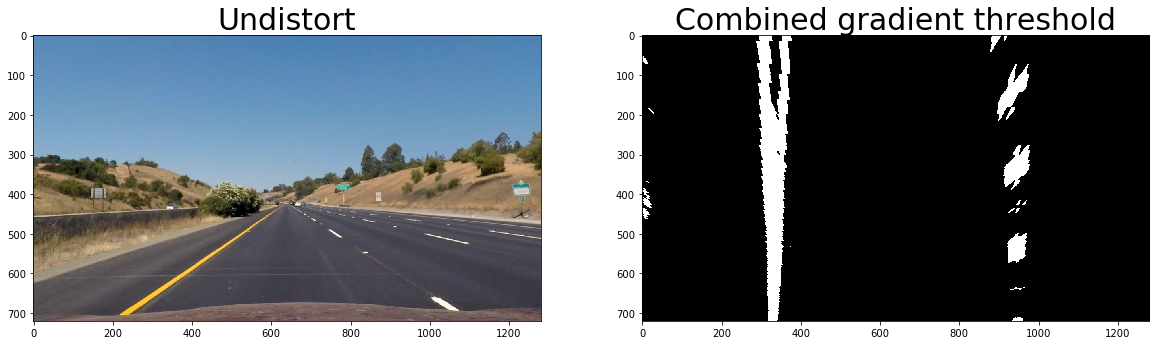

In [20]:
wraped = pers_transform(combined)

f,(ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(undistort)
ax1.set_title('Undistort',fontsize=30)
ax2.imshow(wraped, cmap='gray')
ax2.set_title('Combined gradient threshold',fontsize=30)

# Pipeline

In [21]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
%matplotlib inline

In [22]:
# get the params of camera calibration
with open('..//output_images//wide_dist_pickle.p','rb') as p:
    dist_data = pickle.load(p)
    mtx = dist_data['mtx']
    dist = dist_data['dist']

In [23]:
def get_undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [24]:
# calculate the params of perspective transform
perspective_src = np.float32(
    [[595, 450],
     [688, 450],
     [1058, 688],
     [254, 688]])
perspective_des = np.float32(
    [[330, 0],
     [950, 0],
     [950, 720],
     [330, 720]]
)

M = cv2.getPerspectiveTransform(perspective_src, perspective_des)
res_M = cv2.getPerspectiveTransform(perspective_des,perspective_src)


def get_pers_transform(img_): 
    img_size = (img_.shape[1], img_.shape[0])
    return cv2.warpPerspective(img_, M, img_size, flags=cv2.INTER_LINEAR)

In [25]:
# Sobel Operator
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3,thresh=(50,100)):
    if orient=='x':
        sobel_ = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel_ = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_so = np.absolute(sobel_)
    scaled_so = np.uint8(255*abs_so/np.max(abs_so))
    result = np.zeros_like(scaled_so)
    result[(scaled_so>=thresh[0])&(scaled_so<=thresh[1])] = 1
    return result

# Magnitude of the Gradient
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(70,255)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    gradmag = np.sqrt( sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag>=mag_thresh[0])&(gradmag<=mag_thresh[1])] = 1
    return binary_output

# Direction of the Gradient
def dir_thresh(gray, sobel_kernel=3, dir_thresh=(0.7, 1.3)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    absgraddir = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir>=dir_thresh[0]) & (absgraddir<=dir_thresh[1])] = 1
    
    return binary_output

# Saturation threshold to get binary image
def hls_select(img,l_thresh=(30,200), s_thresh=(165, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Histogram equalization for s channel
    s_channel = cv2.equalizeHist(hls[:, :, 2])
    l_channel = hls[:, :, 1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # get l channel's lanes' pixes
    l_binary_zero = np.zeros_like(l_channel)
    l_binary_zero[l_channel > l_thresh[1]] = 1

    # Exclude shadow interference
    l_binary_one = np.ones_like(l_channel)
    l_binary_one[l_channel < l_thresh[0]] = 0

    s_high = np.zeros_like(l_channel)
    s_high[(s_binary == 1) | (l_binary_zero == 1)] = 1
    s_high_low = np.zeros_like(l_channel)
    s_high_low[(s_high == 1) & (l_binary_one == 1)] = 1
    return s_high_low

#### 梯度阈值集合

In [26]:
def get_gradient_thre(gray):
    ker_size = 9
    gradx = abs_sobel_thresh(gray, orient='x',sobel_kernel=ker_size, thresh=(30,100) )
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ker_size, thresh=(30,100))

    mag_bin = mag_thresh(gray, sobel_kernel=ker_size, mag_thresh=(30,100))
    dir_bin = dir_thresh(gray, sobel_kernel=ker_size, dir_thresh=(0.7,1.3))

    gradient = np.zeros_like(dir_bin)
    gradient[((gradx==1) & (grady==1)) | ((mag_bin==1)&(dir_bin==1))] = 1
    return gradient

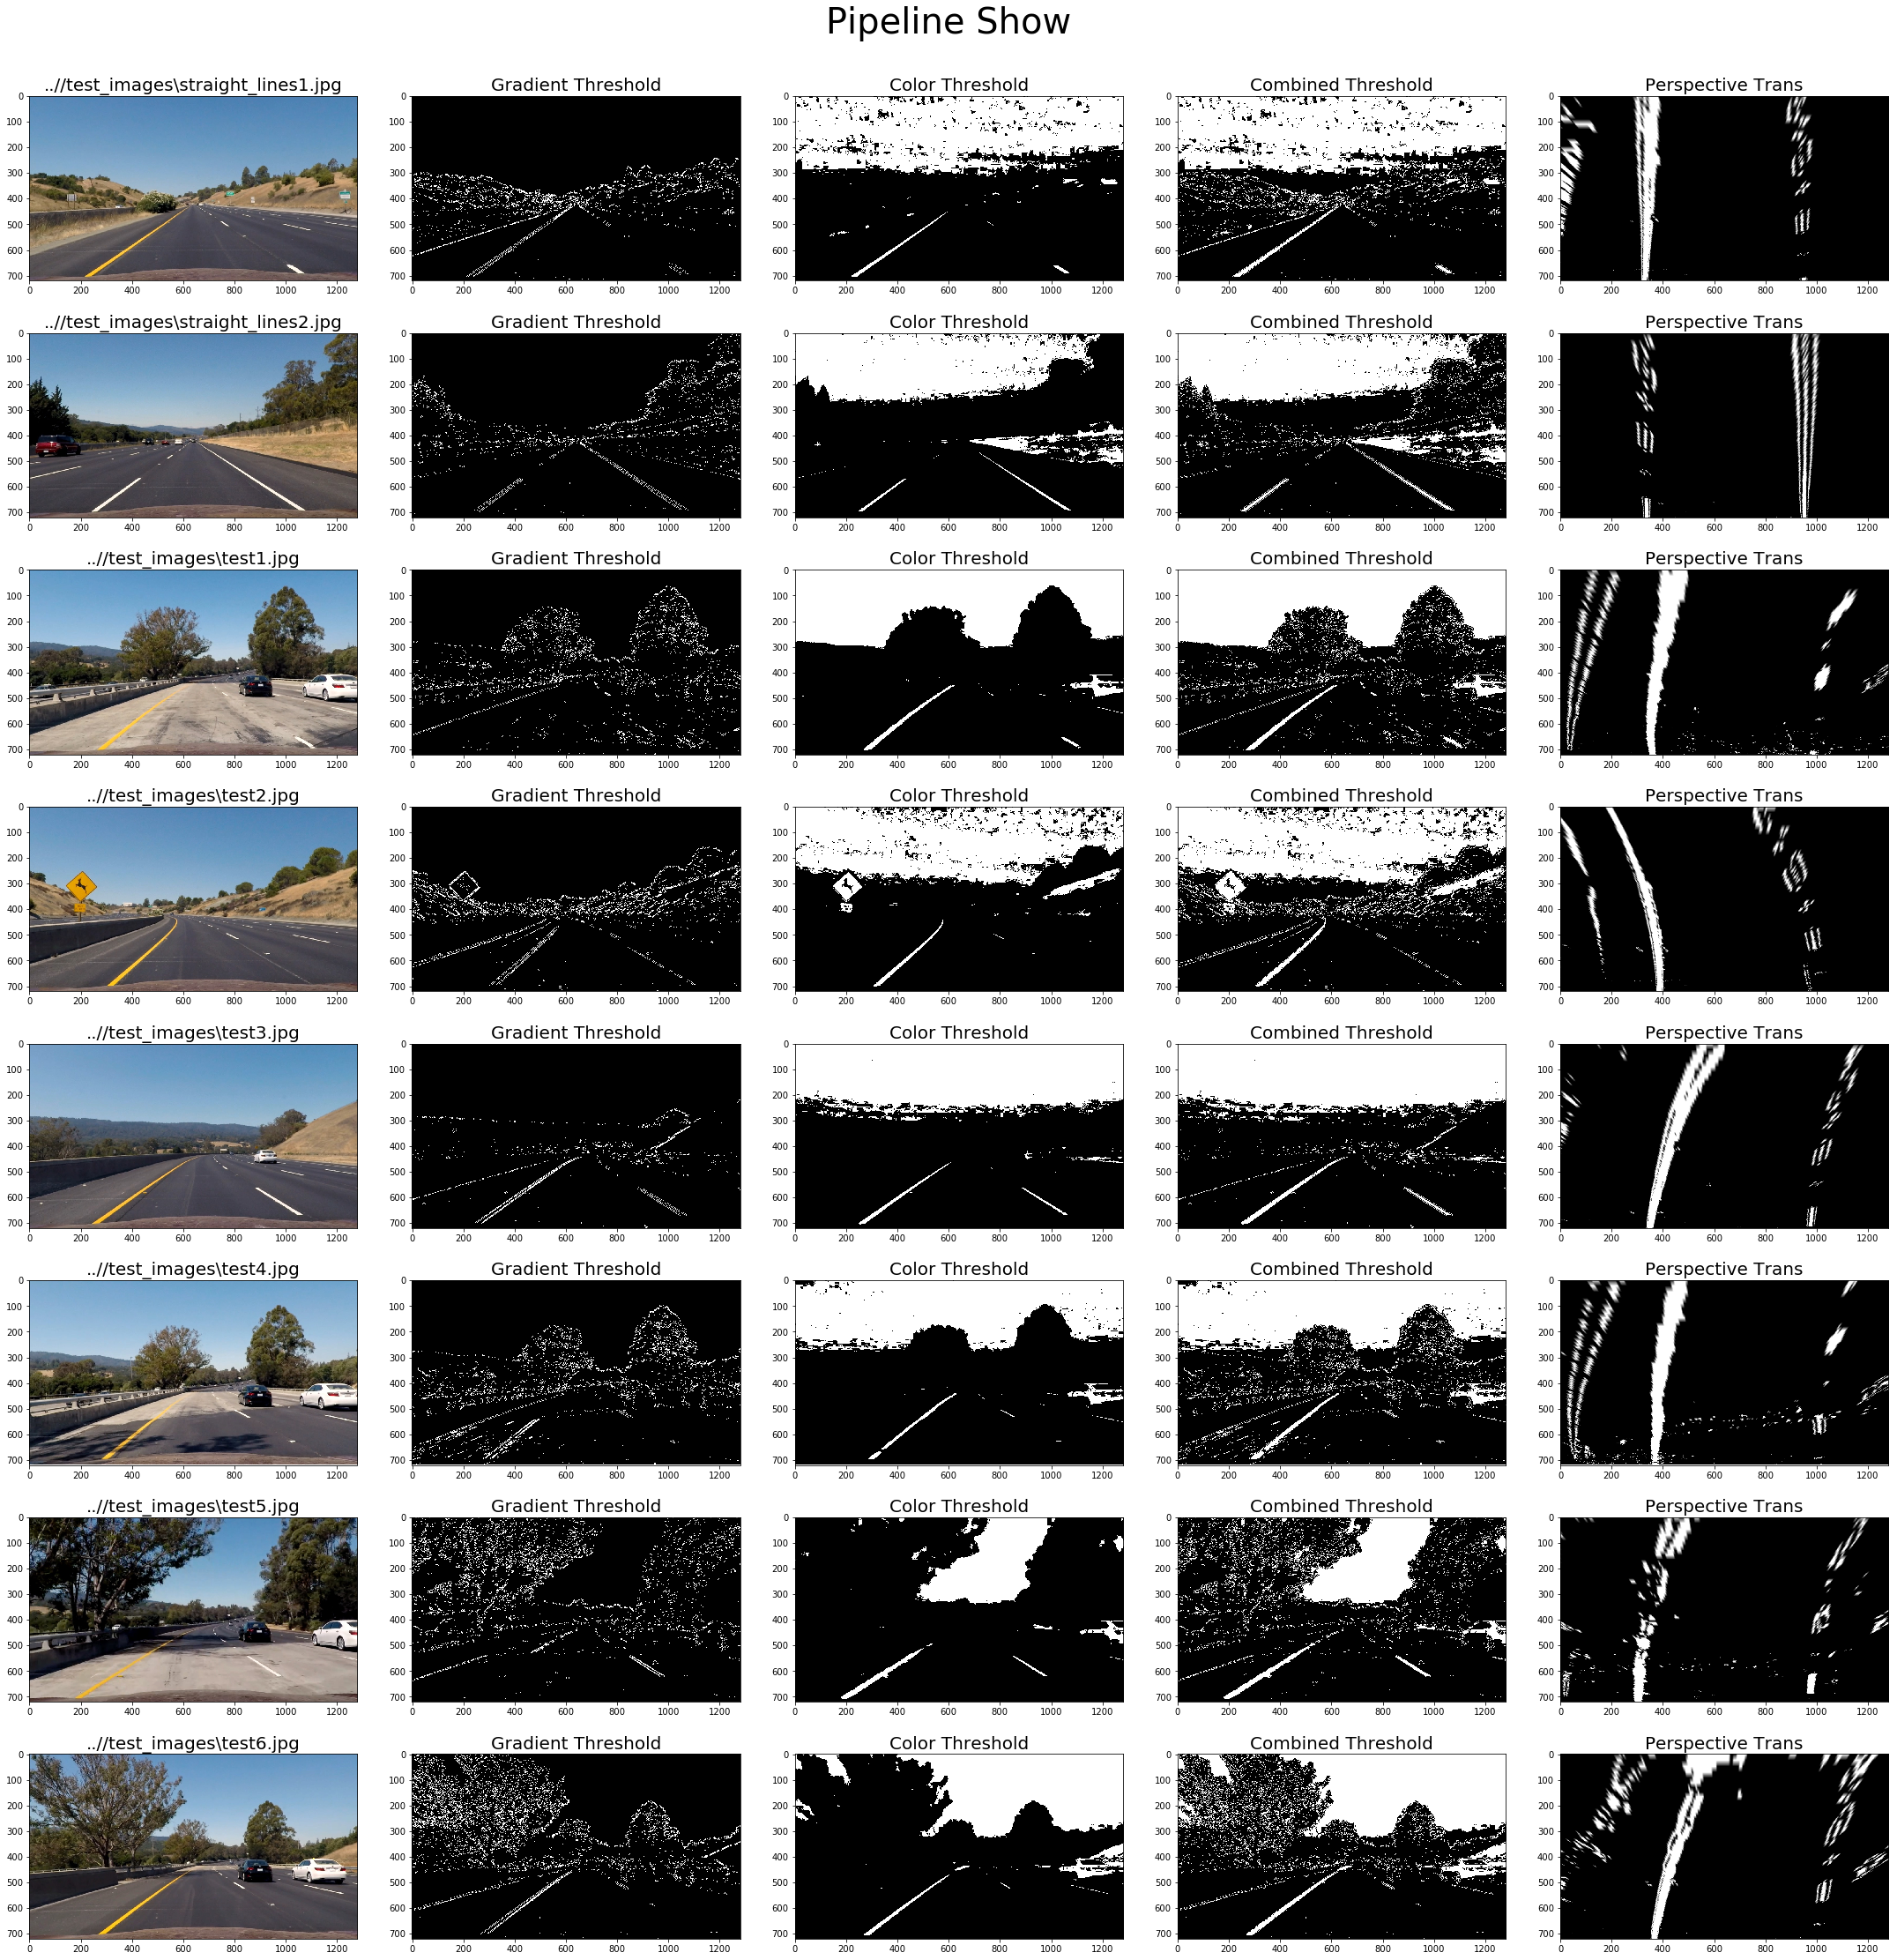

In [27]:
test_imgs = glob.glob('..//test_images//*.jpg')
length = len(test_imgs)

f,axes = plt.subplots(length,5,figsize=(30,30))
for i in range(length):
    img = mpimg.imread(test_imgs[i])
    img = get_undistort(img)
#     cv2.line(img,(688, 450),(1058, 688),(255,0,0),2)
#     cv2.line(img,(595, 450),(254, 688),(255,0,0),2)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    gradient_thre = get_gradient_thre(gray)
    color_thre = hls_select(img,(100,255))
    
    combined = np.zeros_like(gradient_thre)
    combined[(color_thre==1) | (gradient_thre==1)] = 1
    
    pers_tran = get_pers_transform(combined)
    
    axes[i][0].imshow(img,cmap='gray')
    axes[i][0].set_title(test_imgs[i],fontsize = 20)
    
    axes[i][1].imshow(gradient_thre,cmap='gray')
    axes[i][1].set_title('Gradient Threshold',fontsize = 20)
    
    axes[i][2].imshow(color_thre,cmap='gray')
    axes[i][2].set_title('Color Threshold',fontsize = 20)
    
    axes[i][3].imshow(combined,cmap='gray')
    axes[i][3].set_title('Combined Threshold',fontsize = 20)
    
    axes[i][4].imshow(pers_tran,cmap='gray')
    axes[i][4].set_title('Perspective Trans',fontsize = 20)
    
f.suptitle('Pipeline Show', fontsize = 40,x = 0.5,y=1.03)
plt.tight_layout()

### get_binary Function

In [28]:
def get_binary(img):    
    undistort = get_undistort(img)
    gray = cv2.cvtColor(undistort,cv2.COLOR_RGB2GRAY)
    gradient = get_gradient_thre(gray)

    sat_thre = hls_select(undistort,(120,255))
    combined = np.zeros_like(sat_thre)
    combined[(sat_thre==1) | (gradient==1)] = 1
    result = get_pers_transform(combined)
    return result

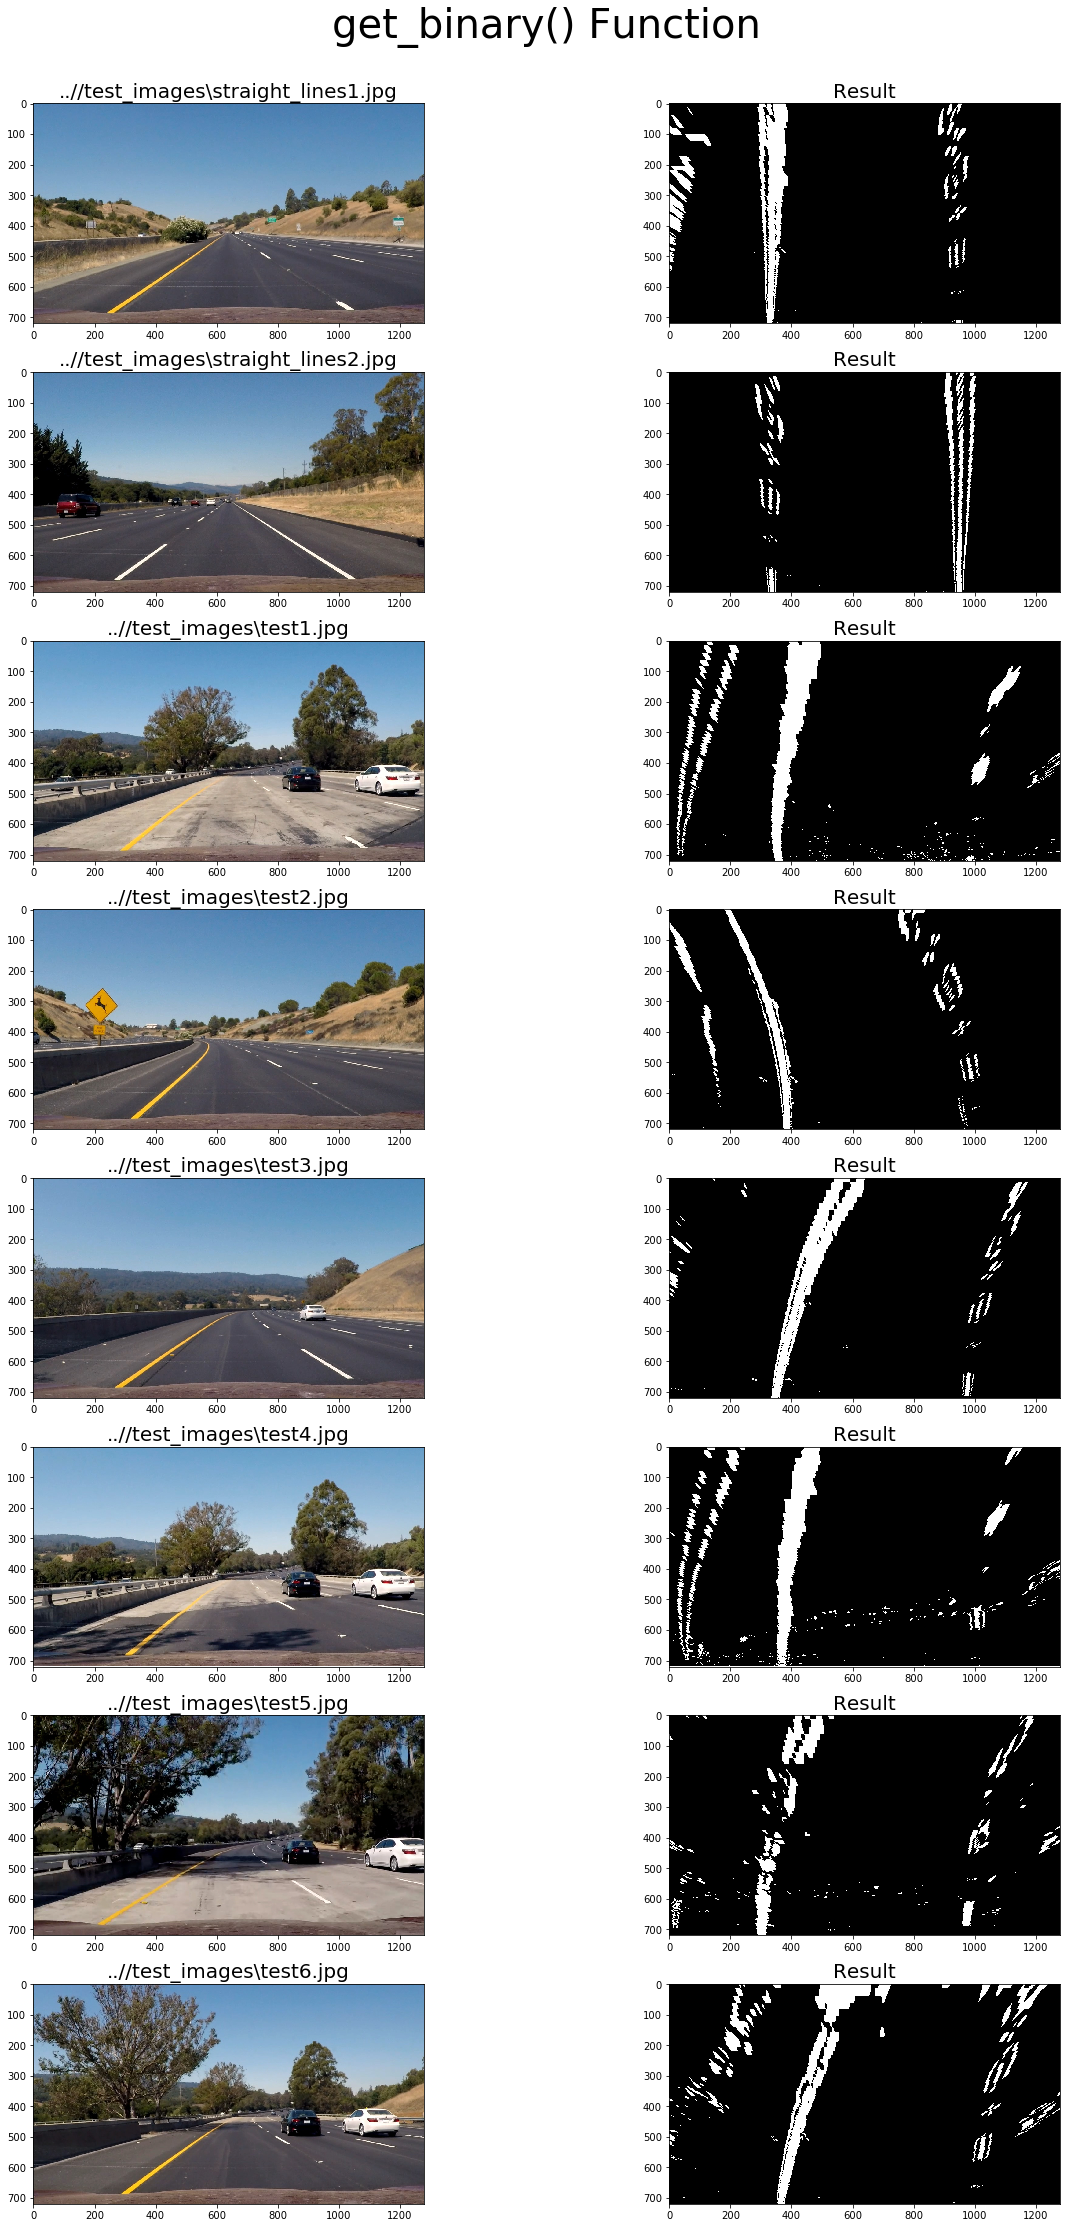

In [29]:
test_imgs = glob.glob('..//test_images//*.jpg')
length = len(test_imgs)

f,axes = plt.subplots(length,2,figsize=(20,30))
for i in range(length):
    img = mpimg.imread(test_imgs[i])
    res = get_binary(img)
    
    axes[i][0].imshow(img)
    axes[i][0].set_title(test_imgs[i],fontsize = 20)
    
    axes[i][1].imshow(res,cmap='gray')
    axes[i][1].set_title('Result',fontsize = 20)
    
    
f.suptitle('get_binary() Function', fontsize = 40,x = 0.5,y=1.03)
plt.tight_layout()